# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Introduction to Data Science
## Lab 3: Optimization in Artificial Neural Networks

**Harvard University**<br>
**Spring 2019**<br>
**Lab instructor**: Eleni Kaxiras<br>
**Instructors:** Pavlos Protopapas and Mark Glickman<br>

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore ways to optimize the loss function of a Multilayer Learning Perceptor (MLP) by tuning the model hyperparameters. We'll also explore the use of cross-validation as a technique for checking potential values for these hyperparameters.

By the end of this lab, you should:
- Be familiar with the use of `sklearn`'s `optimize` function.
- Be able to identify the hyperparameters that go into the training of a MLP.
- Be familiar with the implementation in `keras` of various optimization techniques.
- Know how to use callbacks
- Apply cross-validation to check for multiple values of hyperparameters.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

%matplotlib inline

## Part 1:  Beale's function
### First let's look at function optimization in `scipy.optimize`, using Beale's function as an example

Optimizing a function $f: A\rightarrow R$, from some set A to the real numbers is finding an element $x_0\,\epsilon\, A$ such that $f(x_0)\leq f(x)$ for all $x\,\epsilon\, A$ (finding the minimum) or such that $f(x_0)\geq f(x)$ for all $x\,\epsilon\, A$ (finding the maximum).

To illustrate our point we will use a function of two parameters.  Our goal is to optimize over these 2 parameters. We can extend to higher dimensions by plotting pairs of parameters against each other.

The Wikipedia article on Test functions for optimization has a few functions that are useful for evaluating optimization algorithms. Here is Beale's function:

$f(x,y)$ = $(1.5−x+xy)^2+(2.25−x+xy^2)^2+(2.625−x+xy^3)^2$

We already know that this function has a minimum at [3.0, 0.5]. Let's see if `scipy` will find it.

![alt text](Bealesfunction.jpg)

<pre>source: https://en.wikipedia.org/wiki/Test_functions_for_optimization</pre>

In [3]:
# define Beale's function which we want to minimize
def objective(X):
    x = X[0]; y = X[1]
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [4]:
# function boundaries
xmin, xmax, xstep = -4.5, 4.5, .9
ymin, ymax, ystep = -4.5, 4.5, .9

In [5]:
# Let's create some points
x1, y1 = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

Let's make an initial guess

In [6]:
# initial guess
x0 = [4., 4.]  
f0 = objective(x0)
print (f0)

68891.203125


In [7]:
bnds = ((xmin, xmax), (ymin, ymax))
minimum = minimize(objective, x0, bounds=bnds)

In [8]:
print(minimum)

      fun: 2.068025638865627e-12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.55969780e-06,  9.89837957e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 14
   status: 0
  success: True
        x: array([3.00000257, 0.50000085])


In [9]:
real_min = [3.0, 0.5]
print (f'The answer, {minimum.x}, is very close to the optimum as we know it, which is {real_min}') 
print (f'The value of the objective for {real_min} is {objective(real_min)}')

The answer, [3.00000257 0.50000085], is very close to the optimum as we know it, which is [3.0, 0.5]
The value of the objective for [3.0, 0.5] is 0.0


## Part 2: Optimization in neural networks

In general: **Learning Representation --> Objective function --> Optimization algorithm**

A neural network can be defined as a framework that combines inputs and tries to guess the output. If we are lucky enough to have some results, called "the ground truth", to compare the outputs produced by the network, we can calculate the **error**. So the network guesses, calculates some error function, guesses again, trying to minimize this error, guesses again, until the error does not go down any more. This is optimization.  

In neural networks the most common used optimization algorithms, are flavors of **GD (gradient descent)**. The *objective function* used in gradient descent is the *loss function* which we want to minimize .

### A `keras` Refresher

`Keras` is a Python library for deep learning that can run on top of both Theano or
TensorFlow, two powerful Python libraries for fast numerical computing created and released by Facebook and Google, respectevely.

Keras was developed to make developing deep learning models as fast and easy as
possible for research and practical applications. It runs on Python 2.7 or 3.5 and can seamlessly execute on GPUs and CPUs.

Keras is built on the idea of a model. At its core we have a sequence of layers called
the `Sequential` model which is a linear stack of layers. Keras also provides the `functional API`, a way to define complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

We can summarize the construction of deep learning models in Keras using the Sequential model as follows:
1. **Define your model**: create a `Sequential` model and add layers.
2. **Compile your model**: specify loss function and optimizers and call the `.compile()` function.
3. **Fit your model**: train the model on data by calling the `.fit()` function.
4. **Make predictions**: use the model to generate predictions on new data by calling functions such as `.evaluate()` or `.predict()`.

### Callbacks: taking a peek into our model while it's training

You can look at what is happening in various stages of your model by using `callbacks`. A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the `.fit()` method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

- A callback function you are already familiar with is `keras.callbacks.History()`. This is automatically included in `.fit()`.


- Another very useful one is `keras.callbacks.ModelCheckpoint` which saves the model with its weights at a certain point in the training. This can prove useful if your model is running for a long time and a system failure happens. Not all is lost then. It's a good practice to save the model weights only when an improvement is observed as measured by the `acc`, for example.


- `keras.callbacks.EarlyStopping` stops the training when a monitored quantity has stopped improving.


- `keras.callbacks.LearningRateScheduler` will change the learning rate during training.


We will apply some callbacks later.

For full documentation on `callbacks` see https://keras.io/callbacks/

### What are the steps to optimizing our network?

In [10]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


Using TensorFlow backend.


In [11]:
# fix random seed for reproducibility
np.random.seed(5)

### Step 1 -  Deciding on the network topology (not really considered optimization but is obviously very important)

We will use the MNIST dataset which consists of grayscale images of handwritten digits (0-9) whose dimension is 28x28 pixels. Each pixel is 8 bits so its value ranges from 0 to 255.

In [12]:
#mnist = tf.keras.datasets.mnist
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Each label is a number between 0 and 9

In [13]:
print(y_train)

[5 0 4 ... 5 6 8]


Let's look at some 10 of the images

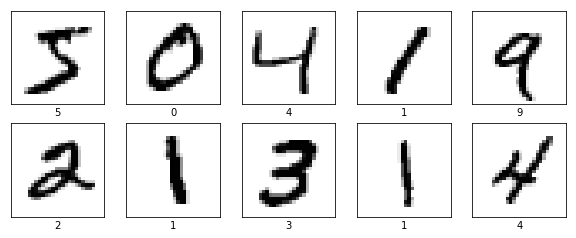

In [14]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [15]:
x_train[45].shape
x_train[45, 15:20, 15:20]

array([[ 11, 198, 231,  41,   0],
       [ 82, 252, 204,   0,   0],
       [253, 253, 141,   0,   0],
       [252, 220,  36,   0,   0],
       [252,  96,   0,   0,   0]], dtype=uint8)

In [17]:
print(f'We have {x_train.shape[0]} train samples')
print(f'We have {x_test.shape[0]} test samples')

We have 60000 train samples
We have 10000 test samples


#### Preprocessing the data

To run our NN we need to pre-process the data

* First we need to make the 2D image arrays into 1D (flatten them). We can either perform this by using array reshaping with `numpy.reshape()` or the `keras`' method for this: a layer called `tf.keras.layers.Flatten` which transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1D-array of 28 * 28 = 784 pixels. 

* Then we need to normalize the pixel values (give them values between 0 and 1) using the following transformation:

\begin{align}
x := \dfrac{x - x_{min}}{x_{max} - x_{min}} 
\textrm{}
\end{align}

In our case $x_{min} = 0$ and $x_{max} = 255$ so the formula becomes simply $x := {x}/255$ 

In [18]:
# normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

In [19]:
# reshape the data into 1D vectors
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

num_classes = 10

In [20]:
x_train.shape[1]

784

Now let's prepare our class vector (y) to a binary class matrix, e.g. for use with categorical_crossentropy.

In [21]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready to build the model!

### Step 2 - Adjusting the `learning rate`

One of the most common optimization algorithm is Stochastic Gradient Descent (SGD). The hyperparameters that can be optimized in SGD are `learning rate`, `momentum`, `decay` and `nesterov`.

`Learning rate` controls the weight at the end of each batch, and `momentum` controls how much to let the previous update influence the current weight update. `Decay` indicates the learning rate decay over each update, and `nesterov` takes the value True or False depending on if we want to apply Nesterov momentum. Typical values for those hyperparameters are lr=0.01, decay=1e-6, momentum=0.9, and nesterov=True. 

The learning rate hyperparameter goes into the `optimizer` function which we will see below. Keras has a default learning rate scheduler in the `SGD` optimizer that decreases the learning rate during the  stochastic gradient descent optimization algorithm. The learning rate is decreased according to this formula:

\begin{align}
lr = lr * 1./(1. + decay * epoch)
\textrm{}
\end{align}

![learning rates](learningrates.jpeg)

<pre>source: http://cs231n.github.io/neural-networks-3</pre>

Let's implement a learning rate adaptation schedule in `Keras`. We'll start with SGD and a learning rate value of 0.1. We will then train the model for 60
epochs and set the decay argument to 0.0016 (0.1/60). We also include a momentum value of 0.8 since that seems to work well when using an adaptive learning rate. 

In [23]:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [24]:
# build the model
input_dim = x_train.shape[1]

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
lr_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [25]:
%%time
# Fit the model
batch_size = int(input_dim/100)

lr_model_history = lr_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 9s 145us/step - loss: 0.3158 - acc: 0.9043 - val_loss: 0.1467 - val_acc: 0.9550
Epoch 2/60
60000/60000 [==============================] - 8s 136us/step - loss: 0.1478 - acc: 0.9555 - val_loss: 0.1194 - val_acc: 0.9617
Epoch 3/60
60000/60000 [==============================] - 8s 137us/step - loss: 0.1248 - acc: 0.9620 - val_loss: 0.1122 - val_acc: 0.9646
Epoch 4/60
60000/60000 [==============================] - 8s 136us/step - loss: 0.1167 - acc: 0.9638 - val_loss: 0.1075 - val_acc: 0.9681
Epoch 5/60
60000/60000 [==============================] - 8s 137us/step - loss: 0.1103 - acc: 0.9666 - val_loss: 0.1039 - val_acc: 0.9691
Epoch 6/60
60000/60000 [==============================] - 8s 137us/step - loss: 0.1051 - acc: 0.9677 - val_loss: 0.1015 - val_acc: 0.9694
Epoch 7/60
60000/60000 [==============================] - 8s 136us/step - loss: 0.1003 - acc: 0.9691 - val_loss: 0.1002 - 

60000/60000 [==============================] - 8s 137us/step - loss: 0.0703 - acc: 0.9782 - val_loss: 0.0916 - val_acc: 0.9731
Epoch 60/60
60000/60000 [==============================] - 8s 137us/step - loss: 0.0703 - acc: 0.9785 - val_loss: 0.0918 - val_acc: 0.9727
CPU times: user 15min 16s, sys: 3min 41s, total: 18min 57s
Wall time: 8min 37s


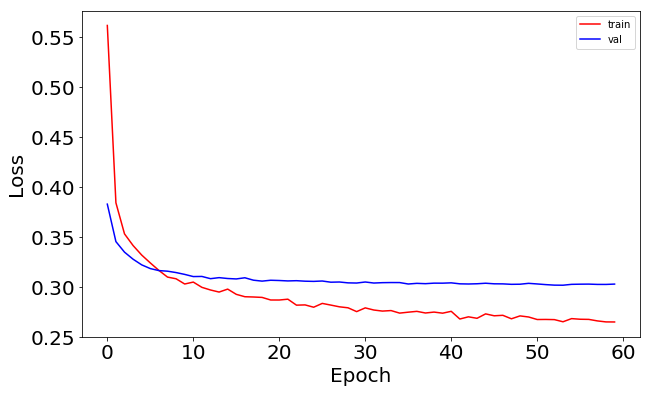

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

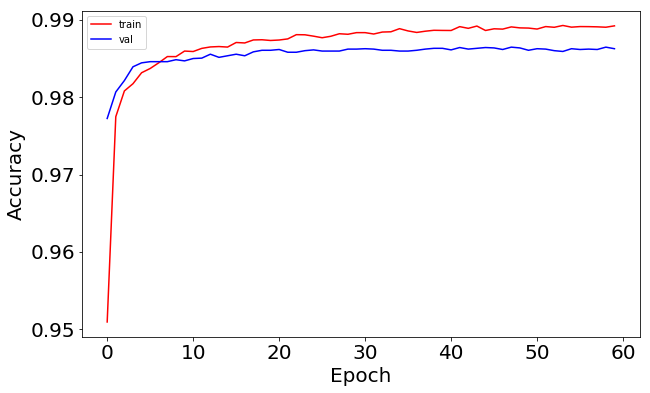

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Exercise 1:  Apply a custon learning rate change using `LearningRateScheduler`
Write a function that performs the exponential learning rate decay as indicated by the following formula:

\begin{align}
lr = lr0 * e^{(-kt)} 
\textrm{}
\end{align}

In [28]:
# your code here

In [29]:
# solution
epochs = 60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [30]:
input_dim = x_train.shape[1]
num_classes = 10
batch_size = 196

# build the model
exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
exponential_decay_model.compile(loss='categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['acc'])

In [31]:
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [32]:
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 16us/step - loss: 1.9924 - acc: 0.3865 - val_loss: 1.4953 - val_acc: 0.5841
Epoch 2/60
60000/60000 [==============================] - 1s 11us/step - loss: 1.2430 - acc: 0.6362 - val_loss: 1.0153 - val_acc: 0.7164
Epoch 3/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.9789 - acc: 0.7141 - val_loss: 0.8601 - val_acc: 0.7617
Epoch 4/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.8710 - acc: 0.7452 - val_loss: 0.7811 - val_acc: 0.7865
Epoch 5/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.8115 - acc: 0.7609 - val_loss: 0.7336 - val_acc: 0.7968
Epoch 6/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.7749 - acc: 0.7678 - val_loss: 0.7030 - val_acc: 0.8035
Epoch 7/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.7524 - acc: 0.7742 - val_loss: 0.6822 - val_acc

60000/60000 [==============================] - 1s 11us/step - loss: 0.6701 - acc: 0.7965 - val_loss: 0.6074 - val_acc: 0.8252


In [33]:
# check on the variables that can show me the learning rate decay
exponential_decay_model_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

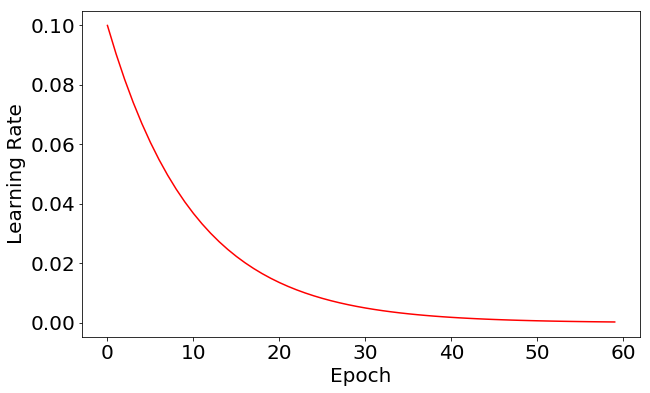

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(exponential_decay_model_history.history['lr'] ,'r') #, label='learn rate')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Learning Rate', fontsize=20)
#ax.legend()
ax.tick_params(labelsize=20)

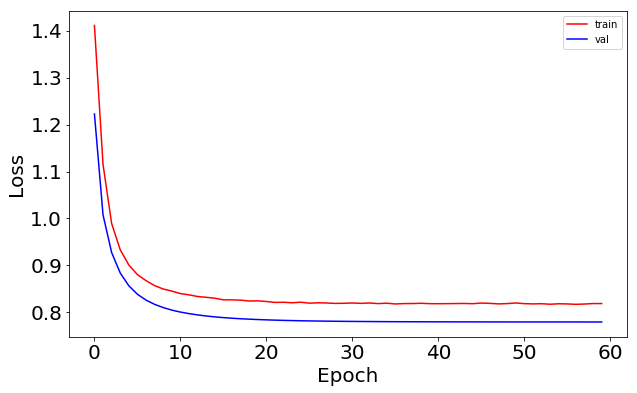

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Step 3 - Choosing an `optimizer` and a `loss function`

When constructing a model and using it to make our predictions, for example to assign label scores to images ("cat", "plane", etc), we want to measure our success or failure by defining a "loss" function (or objective function). The goal of optimization is to efficiently calculate the parameters/weights that minimize this loss function. `keras` provides various types of [loss functions](https://github.com/keras-team/keras/blob/master/keras/losses.py).

Sometimes the "loss" function measures the "distance". We can define this "distance" between two data points in various ways suitable to the problem or dataset.

Distance 

- Euclidean 
- Manhattan
- others such as Hamming which measures distances between strings, for example. The Hamming distance of "carolin" and "cathrin" is 3.

Loss functions
- MSE (for regression)
- categorical cross-entropy (for classification)
- binary cross entropy (for classification)

In [40]:
# build the model
input_dim = x_train.shape[1]

model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) # fully-connected layer with 64 hidden units
model.add(Dropout(0.1))
model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

In [41]:
# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['acc'])

### Step 4 - Deciding on the `batch size` and `number of epochs`

In [42]:
%%time
batch_size = input_dim
epochs = 60

model_history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 14us/step - loss: 1.1320 - acc: 0.7067 - val_loss: 0.5628 - val_acc: 0.8237
Epoch 2/60
60000/60000 [==============================] - 0s 8us/step - loss: 0.4831 - acc: 0.8570 - val_loss: 0.3674 - val_acc: 0.8934
Epoch 3/60
60000/60000 [==============================] - 1s 9us/step - loss: 0.3665 - acc: 0.8931 - val_loss: 0.3199 - val_acc: 0.9061
Epoch 4/60
60000/60000 [==============================] - 1s 9us/step - loss: 0.3100 - acc: 0.9092 - val_loss: 0.2664 - val_acc: 0.9233
Epoch 5/60
60000/60000 [==============================] - 0s 8us/step - loss: 0.2699 - acc: 0.9206 - val_loss: 0.2295 - val_acc: 0.9326
Epoch 6/60
60000/60000 [==============================] - 0s 8us/step - loss: 0.2391 - acc: 0.9305 - val_loss: 0.2104 - val_acc: 0.9362
Epoch 7/60
60000/60000 [==============================] - 0s 8us/step - loss: 0.2115 - acc: 0.9383 - val_loss: 0.1864 - val_acc: 0.94

60000/60000 [==============================] - 0s 8us/step - loss: 0.0283 - acc: 0.9908 - val_loss: 0.0962 - val_acc: 0.9761
CPU times: user 1min 17s, sys: 7.4 s, total: 1min 24s
Wall time: 29.3 s


In [43]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09620895183624088
Test accuracy: 0.9761


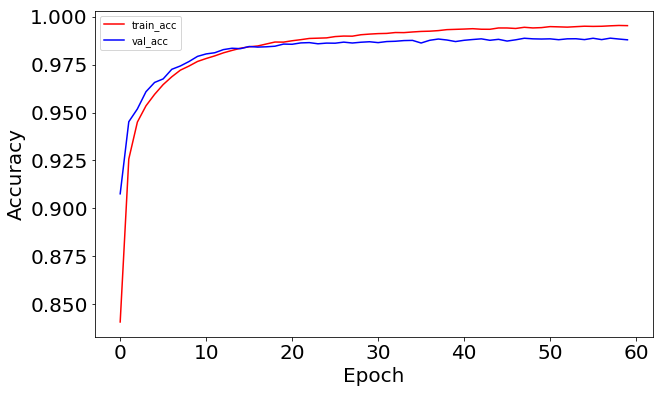

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['acc']), 'r', label='train_acc')
ax.plot(np.sqrt(model_history.history['val_acc']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

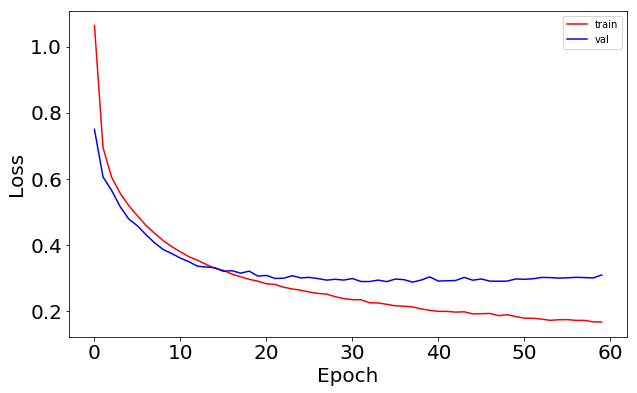

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### Step 5 - Random restarts

This method does not seem to have an implementation in `keras`. We will leave it as a home exercise!

Hint: you can use `keras.callbacks.LearningRateScheduler`. See how we used it to set a custom learning rate.


### Tuning the Hyperparameters using Cross Validation

Now instead of trying different values by hand, we will use GridSearchCV from Scikit-Learn to try out several values for our hyperparameters and compare the results.

To do cross-validation with `keras` we will use the wrappers for the Scikit-Learn API. They provide a way to use Sequential Keras models (single-input only) as part of your Scikit-Learn workflow.

There are two wrappers available:

`keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_params)`, which implements the Scikit-Learn classifier interface,

`keras.wrappers.scikit_learn.KerasRegressor(build_fn=None, **sk_params)`, which implements the Scikit-Learn regressor interface.

In [46]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#### Trying different weight initializations

In [47]:
# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=784)) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

In [49]:
%%time
seed = 7
numpy.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

Epoch 1/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.4118 - acc: 0.8824
Epoch 2/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.1936 - acc: 0.9437
Epoch 3/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.1482 - acc: 0.9553
Epoch 4/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.1225 - acc: 0.9631
Epoch 5/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.1064 - acc: 0.9676
Epoch 6/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.0944 - acc: 0.9710
Epoch 7/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.0876 - acc: 0.9732
Epoch 8/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0809 - acc: 0.9745
Epoch 9/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.0741 - acc: 0.9775
Epoch 10/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.0709 - acc: 0.9783

In [50]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9689333333333333 using {'init_mode': 'lecun_uniform'}
 mean=0.9647, std=0.001438 using {'init_mode': 'uniform'}
 mean=0.9689, std=0.001044 using {'init_mode': 'lecun_uniform'}
 mean=0.9651, std=0.001515 using {'init_mode': 'normal'}
 mean=0.1124, std=0.002416 using {'init_mode': 'zero'}
 mean=0.9657, std=0.0005104 using {'init_mode': 'glorot_normal'}
 mean=0.9687, std=0.0008436 using {'init_mode': 'glorot_uniform'}
 mean=0.9681, std=0.002145 using {'init_mode': 'he_normal'}
 mean=0.9685, std=0.001952 using {'init_mode': 'he_uniform'}


### Save Your Neural Network Model to JSON

The Hierarchical Data Format (HDF5) is a data storage format for storing large arrays of data including values for the weights in a neural network.
You can install HDF5 Python module: pip install h5py

Keras gives you the ability to describe and save any model using the JSON format.

In [51]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# save weights to HDF5
model.save_weights("model.h5")
print("Model saved")

# when you want to retrieve the model: load json and create model
json_file = open('model.json', 'r')
saved_model = json_file.read()
# close the file as good practice
json_file.close()
model_from_json = model_from_json(saved_model)
# load weights into new model
model_from_json.load_weights("model.h5")
print("Model loaded")

Model saved
Model loaded


### Exercise 2: Cross-validation with more than one hyperparameters

We can do cross-validation with more than one parameters simultaneously, effectively trying out combinations of them.  

**Note: Cross-validation in neural networks is computationally expensive**. Think before you experiment! Multiply the number of features you are validating on to see how many combinations there are. Each combination is evaluated using the cv-fold cross-validation (cv is a parameter we choose). 

For example, we can choose to search for different values of:

- batch size, 
- number of epochs and 
- initialization mode. 

The choises are specifed into a dictionary and passed to GridSearchCV. 

Perform a GridSearch for `batch size`, `number of epochs` and `initializer` combined.

In [52]:
#your code here


In [53]:
# solutions

# repeat some of the initial values here so we make sure they were not changed
input_dim = x_train.shape[1]
num_classes = 10

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model_2(optimizer='rmsprop', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init, activation=tf.nn.relu))
    model.add(Dense(num_classes, kernel_initializer=init, activation=tf.nn.softmax))

    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])

    return model

In [54]:
%%time
# fix random seed for reproducibility (this might work or might not work 
# depending on each library's implenentation)
seed = 7
numpy.random.seed(seed)

# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(build_fn=create_model_2, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
init_mode = ['glorot_uniform', 'uniform'] 
batches = [128, 512]
epochs = [10, 20]

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(x_train, y_train)

Epoch 1/10
40000/40000 [==============================] - 1s 21us/step - loss: 0.4801 - acc: 0.8601
Epoch 2/10
40000/40000 [==============================] - 1s 15us/step - loss: 0.2309 - acc: 0.9310
Epoch 3/10
40000/40000 [==============================] - 1s 14us/step - loss: 0.1744 - acc: 0.9479
Epoch 4/10
40000/40000 [==============================] - 1s 15us/step - loss: 0.1422 - acc: 0.9575
Epoch 5/10
40000/40000 [==============================] - 1s 14us/step - loss: 0.1214 - acc: 0.9625
Epoch 6/10
40000/40000 [==============================] - 1s 15us/step - loss: 0.1081 - acc: 0.9675
Epoch 7/10
40000/40000 [==============================] - 1s 15us/step - loss: 0.0974 - acc: 0.9693
Epoch 8/10
40000/40000 [==============================] - 1s 15us/step - loss: 0.0874 - acc: 0.9730
Epoch 9/10
40000/40000 [==============================] - 1s 14us/step - loss: 0.0800 - acc: 0.9750
Epoch 10/10
40000/40000 [==============================] - 0s 6us/step
Epoch 1/10
40000/40000 [=====

40000/40000 [==============================] - 1s 15us/step - loss: 0.0549 - acc: 0.9836
Epoch 16/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0512 - acc: 0.9837
Epoch 17/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0464 - acc: 0.9855
Epoch 18/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0466 - acc: 0.9850
Epoch 19/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0431 - acc: 0.9863
Epoch 20/20
40000/40000 [==============================] - 0s 7us/step
Epoch 1/20
40000/40000 [==============================] - 1s 25us/step - loss: 0.4956 - acc: 0.8584
Epoch 2/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.2286 - acc: 0.9321
Epoch 3/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.1746 - acc: 0.9474
Epoch 4/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.1438 - acc: 0.9574
Epoch 5/20
40000/40000 [============

40000/40000 [==============================] - 1s 15us/step - loss: 0.0838 - acc: 0.9739
Epoch 12/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0788 - acc: 0.9749
Epoch 13/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0720 - acc: 0.9779
Epoch 14/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0685 - acc: 0.9793
Epoch 15/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0666 - acc: 0.9797
Epoch 16/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0618 - acc: 0.9807
Epoch 17/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0578 - acc: 0.9819
Epoch 18/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0557 - acc: 0.9825
Epoch 19/20
40000/40000 [==============================] - 1s 15us/step - loss: 0.0535 - acc: 0.9831
Epoch 20/20
40000/40000 [==============================] - 0s 7us/step
Epoch 1/20
40000/40000 [========

40000/40000 [==============================] - 0s 8us/step - loss: 0.2443 - acc: 0.9285
Epoch 7/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.2141 - acc: 0.9383
Epoch 8/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.1919 - acc: 0.9445
Epoch 9/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.1767 - acc: 0.9485
Epoch 10/10
40000/40000 [==============================] - 0s 4us/step
Epoch 1/10
40000/40000 [==============================] - 1s 25us/step - loss: 1.0997 - acc: 0.7128
Epoch 2/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.4652 - acc: 0.8638
Epoch 3/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.3716 - acc: 0.8919
Epoch 4/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.3165 - acc: 0.9072
Epoch 5/10
40000/40000 [==============================] - 0s 8us/step - loss: 0.2735 - acc: 0.9199
Epoch 6/10
40000/40000 [========================

40000/40000 [==============================] - 0s 8us/step - loss: 0.4792 - acc: 0.8568
Epoch 3/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.3712 - acc: 0.8910
Epoch 4/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.3155 - acc: 0.9068
Epoch 5/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.2746 - acc: 0.9196
Epoch 6/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.2392 - acc: 0.9293
Epoch 7/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.2126 - acc: 0.9363
Epoch 8/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.1923 - acc: 0.9437
Epoch 9/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.1706 - acc: 0.9489
Epoch 10/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.1591 - acc: 0.9530
Epoch 11/20
40000/40000 [==============================] - 0s 8us/step - loss: 0.1462 - acc: 0.9560
Epoch 12/20
40000/4

60000/60000 [==============================] - 1s 17us/step - loss: 0.0439 - acc: 0.9861
CPU times: user 7min 56s, sys: 1min 6s, total: 9min 3s
Wall time: 3min 43s


In [55]:
# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9712 using {'batch_size': 128, 'epochs': 20, 'init': 'glorot_uniform'}
mean=0.9687, std=0.002174 using {'batch_size': 128, 'epochs': 10, 'init': 'glorot_uniform'}
mean=0.966, std=0.000827 using {'batch_size': 128, 'epochs': 10, 'init': 'uniform'}
mean=0.9712, std=0.0006276 using {'batch_size': 128, 'epochs': 20, 'init': 'glorot_uniform'}
mean=0.97, std=0.001214 using {'batch_size': 128, 'epochs': 20, 'init': 'uniform'}
mean=0.9594, std=0.001476 using {'batch_size': 512, 'epochs': 10, 'init': 'glorot_uniform'}
mean=0.9516, std=0.003239 using {'batch_size': 512, 'epochs': 10, 'init': 'uniform'}
mean=0.9684, std=0.003607 using {'batch_size': 512, 'epochs': 20, 'init': 'glorot_uniform'}
mean=0.9633, std=0.0007962 using {'batch_size': 512, 'epochs': 20, 'init': 'uniform'}
